In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io

In [2]:
data = scipy.io.loadmat('Data/ex4data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [3]:
X = data['X']
y = data['y']

In [4]:
m, n = X.shape

In [5]:
# X = np.concatenate((np.ones([m,1]), X), axis=1)
X.shape

(5000, 400)

In [6]:
#convert the vector y into an array
# y = np.squeeze(y) 
y.shape 

(5000, 1)

In [7]:
# y = np.where(y == 10, 0, y)
# y

In [8]:
K = len(np.unique(y))
K

10

In [9]:
weights = scipy.io.loadmat('Data/ex4weights.mat')
weights.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [10]:
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']

In [11]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [12]:
def gradientSigmoid(z):
    return sigmoid(z)*(1-sigmoid(z))

In [13]:
#Convert y array into a matrix Y with dimensions m x K
#Y[0,:] = array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)
# Y = np.tile(y, (1,K))
# for k in range(K): #0...9
#     Y[:,k] = np.where(Y[:,k] == k, 1, 0)
# Y.shape

#In this exercise it is important the order of Y matrix:
#Matlab order, this is 1...10, and not 0...9, then Y[0,:] = array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)
Y = np.tile(y, (1,K)) #1...10
for k in range(1,K+1):
    Y[:,k-1] = np.where(Y[:,k-1] == k, 1, 0)
Y.shape

(5000, 10)

In [14]:
Y[0,:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [15]:
#How to multiply element-wise matrices

# A = np.ones([3,3])
# B = 9*np.ones([3,3])
# np.tensordot(A,B)
#A.ravel().dot(B.ravel())
#np.einsum('ij, ij', A,B) 
#np.sum(np.multiply(A,B))
#sum(sum(A*B)) 

# Feedforward Propagation

In [16]:
def forward_propagation(X, Theta1, Theta2):
    '''
    X: matrix of m x n (without the vector of bias X[0,:] != 0)
    all the matrix obtained will have dimensions m x something
    '''
    m = X.shape[0]
    a1 = np.concatenate((np.ones([m,1]),X), axis=1)
    z2 = a1 @ Theta1.T
    a2 = np.concatenate((np.ones([m,1]), sigmoid(z2)), axis=1) 
    z3 = a2 @ Theta2.T
    a3 = np.concatenate((np.ones([m,1]), sigmoid(z3)), axis=1)  #h_Theta
    return a1, z2, a2, z3, a3

In [17]:
#the difference between logistic regression and neural network is that 
#in neural networks there is not explicit expression to compute derivative of cost function, 
#because rule chain, hence it is neccesary to use backpropagation
def costFunctionReg(Theta1, Theta2, X, Y, Lambda):
    m, K = Y.shape 
    a1, z2, a2, z3, h_Theta = forward_propagation(X, Theta1, Theta2)
    costTerm = -(1/m)*(np.tensordot(Y, np.log(h_Theta[:,1:])) + np.tensordot((np.ones([m,K])-Y), np.log((np.ones([m,K])- h_Theta[:,1:]))))
    #costTerm = -(1/m)*(np.einsum('ij, ij',Y, np.log(h_Theta)) + np.einsum('ij, ij', (np.ones([m,K])-Y), np.log((np.ones([m,K])- h_Theta))))
    regularizationTerm = (Lambda/(2*m))*((np.linalg.norm(Theta1[:,1:])**2) + (np.linalg.norm(Theta2[:,1:])**2))
    J = costTerm + regularizationTerm  
    return J

In [18]:
Lambda = 0
costFunctionReg(Theta1, Theta2, X, Y, Lambda)

0.2876291651613189

In [19]:
Lambda = 1
costFunctionReg(Theta1, Theta2, X, Y, Lambda)

0.38376985909092365

# Random Initialization

In [20]:
def random_initialization(s1,s2,s3,epsilon_init):
    W1 = np.random.randn(s2, s1 + 1)*2*epsilon_init - epsilon_init
    W2 = np.random.randn(s3, s2 + 1)*2*epsilon_init - epsilon_init
    return W1, W2

# Backprogation: Derivatives

In [21]:
A1, Z2, A2, Z3, H_Theta = forward_propagation(X, Theta1, Theta2)
gradientSigmoid(Z2[0,:]).shape

(25,)

In [22]:
def backpropagation(Theta1, Theta2, X, Y, Lambda):
    A1, Z2, A2, Z3, H_Theta = forward_propagation(X, Theta1, Theta2)
    
    Delta_1 = np.zeros(Theta1.shape) #np.zeros([s2, s1 + 1])
    Delta_2 = np.zeros(Theta2.shape) #np.zeros([s3, s2 + 1])
    
    m  = X.shape[0] #5000
   
    for t in range(m):
        #input of neural network: training example xt
        a1 = np.array(A1[t,:]) 
        
        #forward propagation to compute a^(l) with l=2,3
        z2 = np.array(Z2[t,:])
        a2 = np.array(A2[t,:])
        z3 = np.array(Z3[t,:])
        a3 = np.array(H_Theta[t,:])

        #errors
        y_t = np.array(Y[t,:])
        delta_3 = a3[1:] - y_t #not include bias unit
        delta_2 = np.multiply((Theta2[:,1:].T@delta_3),gradientSigmoid(z2))# ((25 x 10) x 10x1) * 25x1 = 25x1 

        #Sum of partials derivatives
        Delta_1 += np.outer(delta_2,a1) #25 x 401
        Delta_2 += np.outer(delta_3,a2) #10x26
        
    #Total derivatives 
    D_1 = Delta_1/m
    D_2 = Delta_2/m    
    
    D_1[:,1:] = D_1[:,1:] + (Lambda/m)*Theta1[:,1:] 
    D_2[:,1:] = D_2[:,1:] + (Lambda/m)*Theta2[:,1:] 
    return D_1, D_2

In [23]:
D1, D2 = backpropagation(Theta1, Theta2, X, Y, 1)
D1

array([[ 6.18712766e-05, -2.11248326e-12,  4.38829369e-13, ...,
         7.09042553e-09,  1.84706139e-09,  5.60928898e-13],
       [ 9.38798109e-05,  1.53233736e-12, -1.95174738e-12, ...,
         2.10747891e-08, -8.61281252e-11,  7.08845709e-13],
       [-1.92593606e-04, -1.75530893e-12,  1.63207553e-12, ...,
         4.63501184e-08,  9.48509834e-10, -1.50133620e-12],
       ...,
       [ 6.60569302e-05, -1.77854412e-12, -1.96393620e-12, ...,
        -9.34100149e-09,  1.29689159e-09,  1.80499812e-12],
       [ 2.90522062e-04,  6.10356747e-14,  5.12122016e-13, ...,
         3.33797620e-07, -3.66032512e-08,  7.67523996e-13],
       [-6.33753316e-05,  1.77175372e-12, -1.31503028e-13, ...,
         4.69418663e-09,  2.83929031e-09,  1.75890906e-12]])

In [24]:
def computeNumericalGradient(Theta1, Theta2, X, Y, Lambda, epsilon):
    #Unroll Theta matrix
    theta = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))
    N = len(theta)
    grad = np.zeros(N)
    for i in range(N):
        thetaPlus =  np.array(theta) #np.copy(theta) #np.array(theta) #thetaPlus = theta doesn't work
        thetaPlus[i] += epsilon
        Theta1Plus = thetaPlus[0:Theta1.size].reshape(Theta1.shape)
        Theta2Plus = thetaPlus[Theta1.size:].reshape(Theta2.shape)
        thetaMinus = np.array(theta) #np.copy(theta) #np.array(theta)
        thetaMinus[i] -= epsilon
        Theta1Minus = thetaMinus[0:Theta1.size].reshape(Theta1.shape)
        Theta2Minus = thetaMinus[Theta1.size:].reshape(Theta2.shape)
        J_plus = costFunctionReg(Theta1Plus, Theta2Plus, X, Y, Lambda)
        J_minus = costFunctionReg(Theta1Minus, Theta2Minus, X, Y, Lambda)
        grad[i] = (J_plus - J_minus)/(2*epsilon)
        if i%1000==0:
            print(i)
    return grad

In [25]:
s1 = Theta1.shape[1] - 1
s2 = Theta1.shape[0]
s3 = Theta2.shape[0]
W1, W2 = random_initialization(s1,s2,s3,epsilon_init=0.12)
# appGradient = computeNumericalGradient(Theta1, Theta2, X, Y, Lambda, epsilon=1e-4)
# appGradient

In [26]:
def costFunctionNeuralNetwork(thetaVec, X, Y, Lambda, s2):
    #Rolling matrices
    s1 = X.shape[1]
    s3 = Y.shape[1]
    Theta1 = thetaVec[0:(s2*(s1+1))].reshape(s2, s1+1)
    Theta2 = thetaVec[(s2*(s1+1)):].reshape(s3, s2+1)
    
    #J
    J = costFunctionReg(Theta1, Theta2, X, Y, Lambda) 
    
    #Gradient vector
    D1, D2 = backpropagation(Theta1, Theta2, X, Y, Lambda)
    D = np.concatenate((np.ravel(D1), np.ravel(D2)))
    return J, D

In [27]:
def costFunctionWithoutNeuralNetwork(thetaVec, X, Y, Lambda, s2):
    #Rolling matrices
    s1 = X.shape[1]
    s3 = Y.shape[1]
    Theta1 = thetaVec[0:(s2*(s1+1))].reshape(s2, s1+1)
    Theta2 = thetaVec[(s2*(s1+1)):].reshape(s3, s2+1)
    
    #J
    J = costFunctionReg(Theta1, Theta2, X, Y, Lambda) 
    return J

In [28]:
thetaVec = np.concatenate((np.ravel(W1), np.ravel(W2)))
s2 = Theta1.shape[0]
J, backPropagationGradient = costFunctionNeuralNetwork(thetaVec, X, Y, Lambda, s2)
J

6.920951123041375

In [29]:
#np.linalg.norm(backPropagationGradient - appGradient)/ np.linalg.norm(backPropagationGradient + appGradient)

In [30]:
#method = 'CG' #'TNC'
res = optimize.minimize(costFunctionNeuralNetwork, x0 = thetaVec, method = 'CG', args=(X,Y, Lambda, s2), jac=True, options = {'maxiter': 250})
#res = optimize.minimize(costFunctionWithoutNeuralNetwork, x0 = thetaVec, method = 'CG',  tol=1e-2, args=(X,Y, Lambda, s2), options = {'maxiter': 10, 'disp': True})
theta_vec_sol = res.x
res

     fun: 0.3351695335126919
     jac: array([ 3.15866865e-04, -4.56547343e-07,  3.48834726e-07, ...,
       -1.18694711e-04, -7.23641493e-06,  6.55686408e-05])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 563
     nit: 250
    njev: 563
  status: 1
 success: False
       x: array([-1.26561053e+00, -2.28273672e-03,  1.74417363e-03, ...,
        1.44303586e+00, -1.95326953e+00, -3.89015665e-01])

In [31]:
#Reconstruct solution theta
Theta1_solution = theta_vec_sol[0:s2*(s1 + 1)].reshape(s2,s1+1)
Theta2_solution = theta_vec_sol[s2*(s1+1):].reshape(s3,s2+1)

In [32]:
Theta1_solution

array([[-1.26561053e+00, -2.28273672e-03,  1.74417363e-03, ...,
        -5.09540756e-03,  7.11083621e-03, -1.06362217e-02],
       [-1.07497799e+00, -1.15598143e-02, -1.18676632e-03, ...,
         9.89491463e-03,  4.00474450e-05, -1.46044816e-02],
       [ 1.19123105e-01, -1.23043269e-02, -4.89975685e-03, ...,
        -8.84234875e-03, -2.36757997e-03,  6.53237535e-03],
       ...,
       [-6.12326765e-01, -4.33583987e-03, -1.29866736e-02, ...,
         5.11081208e-03,  4.30826049e-03,  2.06971198e-04],
       [ 1.04692220e+00, -1.39781392e-03, -7.60998455e-03, ...,
         1.31921216e-03, -2.91398552e-02, -7.28542039e-03],
       [ 6.52046539e-01, -6.69225720e-03,  1.09826271e-02, ...,
        -1.83425509e-02, -4.38360121e-03, -1.60603266e-02]])

In [33]:
Theta1

array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
        -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
       [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
        -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
       [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
        -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
       ...,
       [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
         2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
       [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
        -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
       [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
        -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]])

In [34]:
def predictNeuralNetwork(X,theta1, theta2):
    m = X.shape[0]
    prediction_digit = np.zeros(m)
    probability = np.zeros(m)
    a1, z2, a2, z3, a3 = forward_propagation(X, theta1, theta2)
    M = np.argmax(a3[:,1:], axis=1) + 1 
    prediction_digit = M
    #prediction_digit = np.where(M==10,0,M) #because now Y in 1...10
    probability = np.max(a3[:,1:], axis=1) #in each row find the maximum
    return prediction_digit, probability      

In [35]:
#predicted, probability = predictNeuralNetwork(X, Theta1, Theta2)
predicted, probability = predictNeuralNetwork(X,Theta1_solution, Theta2_solution)
correct = np.zeros(m)
correct = np.where(np.squeeze(y) == predicted, 1, 0)
predicted = np.where(predicted == 10, 0, predicted)
print(f'Accuracy = {100*np.mean(correct)}%')

Accuracy = 99.26%


In [36]:
predicted

array([0, 0, 0, ..., 9, 9, 9], dtype=int64)

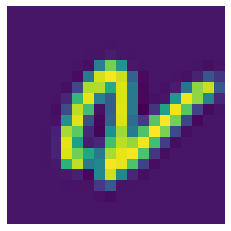

In [37]:
#Prediction of new examples
row = np.random.randint(0, m-1)
for i in range(10):
    for j in range(10):
        digits = X[row,:].reshape(20,20)
        plt.imshow(digits)
        plt.axis('off')
predicted, probability = predictNeuralNetwork(X[row:row+1,:],Theta1_solution, Theta2_solution)

In [38]:
print(f'The digit is {int(predicted[0])}')

The digit is 9
